## Implementing Trading with Machine Learning Regression

Below the steps:

1. [Read NIKKEI data](#read)
2. [Create Input Parameters](#input)
3. [Create X and y Datasets](#xy)
2. [Preprocess the Data](#preprocess)
3. [Grid Search Cross-Validation](#cross)
4. [Split Train and Test Data](#split)
5. [Predict the High-Low Prices](#prediction)
2. [Signal Generation](#returns)
3. [Plotting NIKKEI Returns and Strategy Returns](#plot)
2. [Analyse the Performance](#analyze)
5. [Strategy_Analysis](#analysis)

## Import the Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

import yfinance as yf
import datetime

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#For strategy analysis
import pyfolio as pf

# To ignore unwanted warnings
import warnings
warnings.filterwarnings("ignore")

/var/folders/cp/bkd_fjpn4h3g5xz9g867z6cw0000gn/T/ipykernel_48127/3565572771.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
/Users/hichemheddar/anaconda3/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


<a id='read'></a>
## Fetch NIKKEI data

You can download the data from Yahoo! Finance.

In [2]:
# Define the ticker symbol for NIKKEI index
nikkei_ticker = '^N225'  # NIKKEI ticker symbol

# Define the date range
start_date = datetime.datetime(2013, 4, 15)
end_date = datetime.datetime(2019, 9, 5)

# Fetch the NIKKEI data
nikkei_data = yf.download(nikkei_ticker, start=start_date, end=end_date)

# Print the first few rows of the data
nikkei_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-04-15,13345.860352,13408.290039,13257.860352,13275.660156,13275.660156,321000000
2013-04-16,13023.910156,13312.230469,13004.459961,13221.440430,13221.440430,321600000
2013-04-17,13330.500000,13397.500000,13318.690430,13382.889648,13382.889648,277400000
2013-04-18,13272.219727,13377.740234,13200.849609,13220.070312,13220.070312,305000000
2013-04-19,13268.429688,13338.750000,13186.889648,13316.480469,13316.480469,236000000


Now we will check for the outliers by plotting `Close` column of `NIKKEI_prices`.

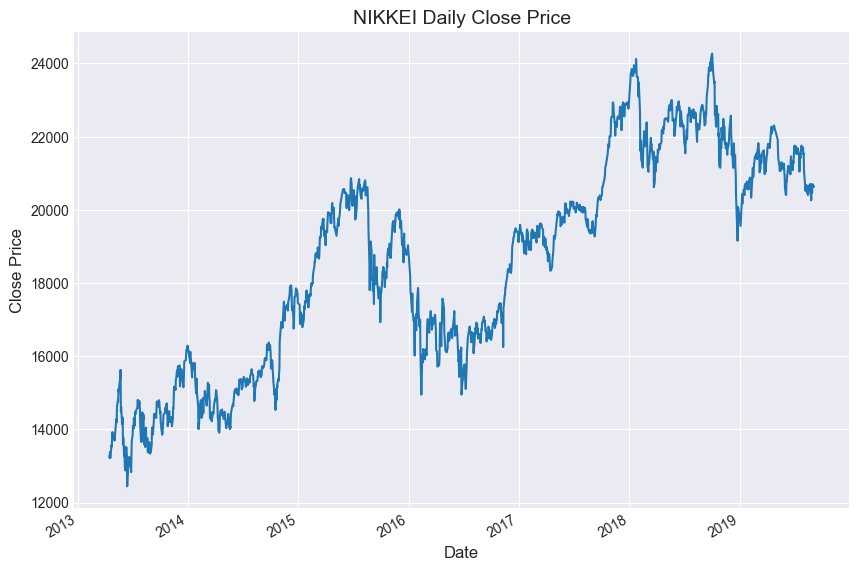

In [3]:
# Plot the closing price of GLD
nikkei_data['Close'].plot(figsize=(10, 7))
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.title('NIKKEI Daily Close Price', fontsize=14)
plt.show()

From the above plot we don't see any outliers. We will check for `NaN` values.

In [4]:
# Here we check for NaN values
nikkei_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Here we can clearly see our data has zero NaN values.
<a id='input'></a>
## Create Input Parameters

We will create custom indicators, which will help in making the prediction more accurate. 

1. `S_3`,`S_15`,`S_60`: 3-days, 15-days and 60-days moving average for NIKKEI `Close` prices, respectively.
2. `Corr`: Compute the correlation between the `Close` price and `S_3`.
3. `Std_U`,`Std_D`: Difference between `High` & `Open`, `Open & Low` respectively.
4. `OD`, `OL`: Difference between `Open` & previous day's `Open`, and `Open` & previous day's `Close` respectively.



In [5]:
# Calculate 3-day moving average of close prices
nikkei_data['S_3'] = nikkei_data['Close'].shift(1).rolling(window=3).mean()

# Calculate 15-day moving average of close prices
nikkei_data['S_15'] = nikkei_data['Close'].shift(1).rolling(window=15).mean()

# Calculate 60-day moving average of close prices
nikkei_data['S_60'] = nikkei_data['Close'].shift(1).rolling(window=60).mean()

# Calculate the correlation between close price and 3 day moving average
nikkei_data['Corr'] = nikkei_data['Close'].shift(
    1).rolling(window=10).corr(nikkei_data['S_3'].shift(1))

# Calculate the difference between High & Open, Open & Low
nikkei_data['Std_U'] = nikkei_data['High']-nikkei_data['Open']
nikkei_data['Std_D'] = nikkei_data['Open']-nikkei_data['Low']

# Calculate the difference between `Open` & previous day's `Open`, and `Open` & previous day's `Close`
nikkei_data['OD'] = nikkei_data['Open']-nikkei_data['Open'].shift(1)
nikkei_data['OL'] = nikkei_data['Open']-nikkei_data['Close'].shift(1)

nikkei_data.tail()

,Open,High,Low,Close,Adj Close,Volume,S_3,S_15,S_60,Corr,Std_U,Std_D,OD,OL
Date,,,,,,,,,,,,,,
2019-08-29,20500.500000,20520.679688,20361.119141,20460.929688,20460.929688,55100000,20398.846354,20541.611458,21131.867741,-0.161994,20.179688,139.380859,26.189453,21.080078
2019-08-30,20641.490234,20748.349609,20633.300781,20704.369141,20704.369141,72000000,20465.476562,20537.902734,21132.740918,0.011936,106.859375,8.189453,140.990234,180.560547
2019-09-02,20625.750000,20667.560547,20614.289062,20620.189453,20620.189453,42400000,20548.239583,20545.304036,21131.545410,-0.116186,41.810547,11.460938,-15.740234,-78.619141
2019-09-03,20581.580078,20662.230469,20578.019531,20625.160156,20625.160156,0,20595.162760,20540.995312,21128.981250,-0.105691,80.650391,3.560547,-44.169922,-38.609375
2019-09-04,20578.669922,20694.349609,20554.160156,20649.140625,20649.140625,51500000,20649.906250,20552.310026,21124.655404,0.012440,115.679688,24.509766,-2.910156,-46.490234


# Checking for NaN Values
Here we will for NaN values, then we will drop all the rows having NaN values using `dropna` method.

In [6]:
nikkei_data.isna().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
S_3           3
S_15         15
S_60         60
Corr         13
Std_U         0
Std_D         0
OD            1
OL            1
dtype: int64

In [7]:
# Dropping all the NaN values
nikkei_data.dropna(inplace=True)

# Checking for NaN values
nikkei_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
S_3          0
S_15         0
S_60         0
Corr         0
Std_U        0
Std_D        0
OD           0
OL           0
dtype: int64

<a id='xy'></a>
## Create X and y Datasets

We will create an input dataset X and output datasets yU and yD for feeding into the linear regression model we are looking to build.


In [8]:
# Independent variables
X = nikkei_data[['Open', 'S_3', 'S_15', 'S_60', 'OD', 'OL', 'Corr']]
X.tail()

,Open,S_3,S_15,S_60,OD,OL,Corr
Date,,,,,,,
2019-08-29,20500.500000,20398.846354,20541.611458,21131.867741,26.189453,21.080078,-0.161994
2019-08-30,20641.490234,20465.476562,20537.902734,21132.740918,140.990234,180.560547,0.011936
2019-09-02,20625.750000,20548.239583,20545.304036,21131.545410,-15.740234,-78.619141,-0.116186
2019-09-03,20581.580078,20595.162760,20540.995312,21128.981250,-44.169922,-38.609375,-0.105691
2019-09-04,20578.669922,20649.906250,20552.310026,21124.655404,-2.910156,-46.490234,0.012440


In [9]:
# Dependent variable for upward deviation
yU = nikkei_data['Std_U']
yU.tail()

Date
2019-08-29     20.179688
2019-08-30    106.859375
2019-09-02     41.810547
2019-09-03     80.650391
2019-09-04    115.679688
Name: Std_U, dtype: float64

In [10]:
# Dependent variable for downward deviation
yD = nikkei_data['Std_D']
yD.tail()

Date
2019-08-29    139.380859
2019-08-30      8.189453
2019-09-02     11.460938
2019-09-03      3.560547
2019-09-04     24.509766
Name: Std_D, dtype: float64

<a id='preprocess'></a>
## Data Preprocessing
Feeding the model with preprocessed data in a machine learning model is essential. Raw data contains many errors, and using such data will result in inconsistent and erroneous results. 


### Scaling
Suppose a feature has a variance of an order of magnitude larger than the other features. In that case, it might dominate the objective function and make the estimator unable to learn from other features correctly. To achieve this, we call the Standard Scaler function.

### Linear Regression
Linear regression uses independent variables to predict a dependent variable using Linear equation. Here we use `X` as independent and `yU`,`yD` as the dependent variable.

## Pipeline

We define a list containing tuples that specify various machine learning tasks given in the order of execution.

In [11]:
# First we put scaling and then linear regression in the pipeline.
steps = [('scaler', StandardScaler()),
         ('linear', LinearRegression())]

# Defining pipeline
pipeline = Pipeline(steps)

## Hyperparameters

Hyperparameters are  parameters that the model itself cannot estimate.But we still need to account for them as they play a crucial role in increasing the performance of the system. 

In [12]:
# Here we are using intercept as hyperparameter
parameters = {'linear__fit_intercept': [0, 1]}

<a id='cross'></a>
## Grid Search Cross-Validation
Cross-validation indicates the model’s performance in a practical situation. It is used to tackle the overfitting of a model. We will use the `GridSearchCV` function.

We have set `cv=5`, which implies that the grid search will consider five rounds of cross-validation for averaging the performance results. We are using `GridSearchCV` instead of `RandomSearchCV` due to fewer features.`TimeSeriesSplit` splits training data into multiple segments.


In [13]:
# Using TimeSeriesSplit for cross validation
my_cv = TimeSeriesSplit(n_splits=5)

# Defining reg as variable for GridSearch function containing pipeline, hyperparameters
reg = GridSearchCV(pipeline, parameters, cv=my_cv)

<a id='split'></a>
## Split Train and Test Data

We will split data into train and test data sets. 

1. First, 70% of data is used for training and the remaining data for testing.
2. Fit the training data to a grid search function.

In [14]:
spilitting_ratio = .70

# Splitting the data into two parts
# Using int to make sure integer number comes out.
split = int(spilitting_ratio*len(nikkei_data))

# Defining train dataset
X_train = X[:split]
yU_train = yU[:split]
yD_train = yD[:split]

# Defining test data
X_test = X[split:]

<a id='prediction'></a>
## Prediction

We will fit the linear regression model on the training dataset and predict the upward deviation in the test dataset. 


In [15]:
# Fit the model
reg.fit(X_train, yU_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('linear', LinearRegression())]),
             param_grid={'linear__fit_intercept': [0, 1]})

After fitting the data, we will pass the `best_params_` to the `reg` model.`best_params_` is a boolean parameter that can only take 0 or 1 as its value, indicating False or True, respectively. It provides us with information regarding the best linear fit intercept for the model.

In [16]:
# Print best parameter
print(reg.best_params_)

{'linear__fit_intercept': 1}


We can see `best_params_` for our model gives `linear_fit_intercept` equal to one.

Here we predict upward deviation using `reg` model on test dataset. We define `yU_predict` for upward prediction.

In [17]:
# Predict the upward deviation
yU_predict = reg.predict(X_test)

Similarly, we will fit the data to predict downward deviation using `X_train` and `yD_train`. Then, we will print `best_params` for the fitted data. After fitting the data, we will predict the downward deviation and assign it to a variable named `yD_predict`.

In [18]:
# Fit the model
reg.fit(X_train, yD_train)

# Print best parameter
print(reg.best_params_)

# Predict the downward deviation
yD_predict = reg.predict(X_test)

{'linear__fit_intercept': 1}


Now we will create `yU_predict` and `yD_predict` columns in the `X_test`.Formulas for upward deviation and downward deviation are given by:

Upward deviation  = High - Open

Downward deviation = Open - Low

It is clear from the above two formulas that upward and downward deviation can not be negative. So, we replace negative values with zero.


In [19]:
# Create new column in X_test
X_test['yU_predict'] = yU_predict
X_test['yD_predict'] = yD_predict

# Assign zero to all the negative predicted values to take into account real life conditions
X_test.loc[X_test['yU_predict'] < 0, 'yU_predict'] = 0
X_test.loc[X_test['yD_predict'] < 0, 'yD_predict'] = 0

We will use the predicted upside deviation values to calculate the high price and the predicted downside deviation values to calculate the low price.

In [20]:
# Add open values in ['yU_predict'] to get the predicted high column
X_test['P_H'] = X_test['Open']+X_test['yU_predict']

# Subtract ['yD_predict'] values in open to get the predicted low column.
X_test['P_L'] = X_test['Open']-X_test['yD_predict']

# Print tail of NIKKEI_prices dataframe
X_test.tail()

,Open,S_3,S_15,S_60,OD,OL,Corr,yU_predict,yD_predict,P_H,P_L
Date,,,,,,,,,,,
2019-08-29,20500.500000,20398.846354,20541.611458,21131.867741,26.189453,21.080078,-0.161994,111.418713,117.155833,20611.918713,20383.344167
2019-08-30,20641.490234,20465.476562,20537.902734,21132.740918,140.990234,180.560547,0.011936,126.396339,97.201949,20767.886573,20544.288285
2019-09-02,20625.750000,20548.239583,20545.304036,21131.545410,-15.740234,-78.619141,-0.116186,90.971603,124.846273,20716.721603,20500.903727
2019-09-03,20581.580078,20595.162760,20540.995312,21128.981250,-44.169922,-38.609375,-0.105691,100.728235,123.946414,20682.308313,20457.633664
2019-09-04,20578.669922,20649.906250,20552.310026,21124.655404,-2.910156,-46.490234,0.012440,95.454434,131.301963,20674.124356,20447.367959


Here we add the `Close`, `High`, and `Low` columns from `NIKKEI_prices` because we will need all these columns to calculate strategy returns in the following notebook.
We are using the split function to get only the test part of the `NIKKEI_prices`.

In [21]:
# Copy columns from NIKKEI_prices to X_test
X_test[['Close', 'High', 'Low']] = nikkei_data[['Close', 'High', 'Low']][split:]
X_test.tail()

,Open,S_3,S_15,S_60,OD,OL,Corr,yU_predict,yD_predict,P_H,P_L,Close,High,Low
Date,,,,,,,,,,,,,,
2019-08-29,20500.500000,20398.846354,20541.611458,21131.867741,26.189453,21.080078,-0.161994,111.418713,117.155833,20611.918713,20383.344167,20460.929688,20520.679688,20361.119141
2019-08-30,20641.490234,20465.476562,20537.902734,21132.740918,140.990234,180.560547,0.011936,126.396339,97.201949,20767.886573,20544.288285,20704.369141,20748.349609,20633.300781
2019-09-02,20625.750000,20548.239583,20545.304036,21131.545410,-15.740234,-78.619141,-0.116186,90.971603,124.846273,20716.721603,20500.903727,20620.189453,20667.560547,20614.289062
2019-09-03,20581.580078,20595.162760,20540.995312,21128.981250,-44.169922,-38.609375,-0.105691,100.728235,123.946414,20682.308313,20457.633664,20625.160156,20662.230469,20578.019531
2019-09-04,20578.669922,20649.906250,20552.310026,21124.655404,-2.910156,-46.490234,0.012440,95.454434,131.301963,20674.124356,20447.367959,20649.140625,20694.349609,20554.160156


In [22]:
# Printing the tail of test_dataset
test_dataset = X_test[['Close', 'High','P_H', 'Low', 'P_L']]

# Printing the tail of test_dataset
test_dataset.tail()

,Close,High,P_H,Low,P_L
Date,,,,,
2019-08-29,20460.929688,20520.679688,20611.918713,20361.119141,20383.344167
2019-08-30,20704.369141,20748.349609,20767.886573,20633.300781,20544.288285
2019-09-02,20620.189453,20667.560547,20716.721603,20614.289062,20500.903727
2019-09-03,20625.160156,20662.230469,20682.308313,20578.019531,20457.633664
2019-09-04,20649.140625,20694.349609,20674.124356,20554.160156,20447.367959


<a id='returns'></a>
## Signal Generation

We will use the predicted high and predicted low values to determine whether to buy or sell NIKKEI the next day.

We will sell NIKKEI when
1. The actual high value is greater than the predicted high value. 
2. The actual low value is greater than the predicted low value.

We will buy NIKKEI when 
1. The actual high value is less than the predicted high value.  
2. The actual low value is less than the predicted low value.


In [23]:
# Initialising signal column to be zero
test_dataset['Signal'] = 0

# When selling, assigning signal value as -1
test_dataset.loc[(test_dataset['High'] > test_dataset['P_H']) & (
    test_dataset['Low'] > test_dataset['P_L']), 'Signal'] = -1

# When buying, assigning signal value as +1
test_dataset.loc[(test_dataset['High'] < test_dataset['P_H']) & (
    test_dataset['Low'] < test_dataset['P_L']), 'Signal'] = 1

## Strategy Returns
Here, we will compute the NIKKEI returns and strategy returns.

`NIKKEI_returns` are simply calculated using percentage change in two consecutive `Close`.

For `test_dataset` we use `Signal` of last day and `NIKKEI_returns`.

In [24]:
# Compute NIKKEI returns
test_dataset['NIKKEI_returns'] = test_dataset['Close'].pct_change()

# Compute strategy returns
test_dataset['strategy_returns'] = test_dataset['NIKKEI_returns'] * \
    (test_dataset['Signal'].shift(1))

# Printing tail of the test_dataset
test_dataset.tail()

,Close,High,P_H,Low,P_L,Signal,NIKKEI_returns,strategy_returns
Date,,,,,,,,
2019-08-29,20460.929688,20520.679688,20611.918713,20361.119141,20383.344167,1,-0.000903,-0.000000
2019-08-30,20704.369141,20748.349609,20767.886573,20633.300781,20544.288285,0,0.011898,0.011898
2019-09-02,20620.189453,20667.560547,20716.721603,20614.289062,20500.903727,0,-0.004066,-0.000000
2019-09-03,20625.160156,20662.230469,20682.308313,20578.019531,20457.633664,0,0.000241,0.000000
2019-09-04,20649.140625,20694.349609,20674.124356,20554.160156,20447.367959,-1,0.001163,0.000000


<a id='plot'></a>
## Plot the NIKKEI Returns and Strategy Returns
Here we will plot `NIKKEI_returns` and `test_dataset` in one plot for comparison.

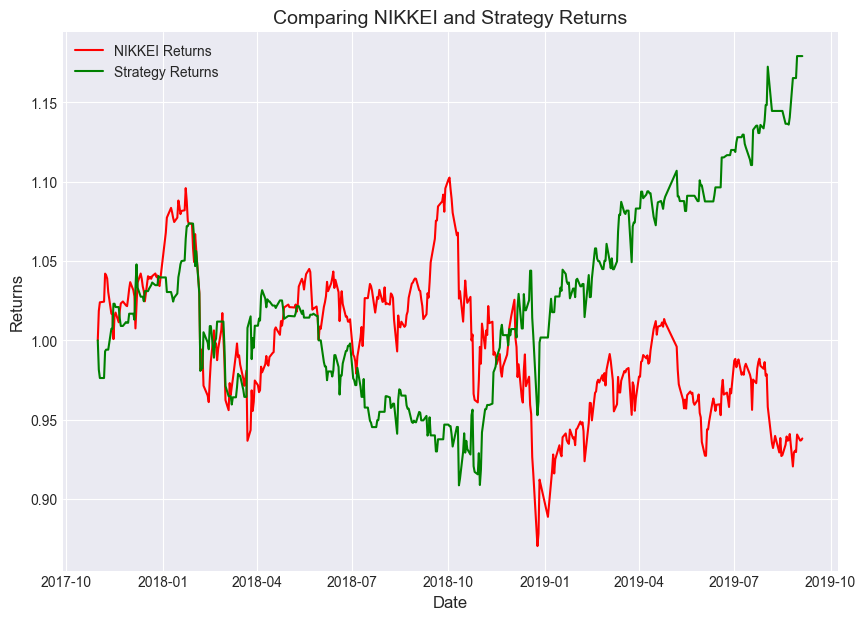

In [25]:
plt.figure(figsize=(10, 7))

# Plotting gld_returns
plt.plot(((test_dataset['NIKKEI_returns'][:]+1).cumprod()),
         color='r', label='NIKKEI Returns')

# Plotting test_dataset
plt.plot(((test_dataset['strategy_returns'][:]+1).cumprod()),
         color='g', label='Strategy Returns')

# x-labeling
plt.xlabel('Date', fontsize=12)

# y-labeling
plt.ylabel('Returns', fontsize=12)

# Titlename
plt.title('Comparing NIKKEI and Strategy Returns', fontsize=14)
plt.legend()
plt.show()

In [26]:
strategy_data = test_dataset

<a id='analyze'></a>
## Analyse the Performance
First, we will use the Sharpe ratio to analyze the performance. Later in this notebook, we will examine our strategy in detail. 

### Sharpe Ratio
Sharpe ratio is a measure for calculating risk-adjusted return. It is the ratio of the excess expected return of investment (over risk-free rate) per unit of volatility or standard deviation.


In [27]:
# The below function returns the Sharpe ratio for the excess returns
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()


# Calculate the excess daily return by assuming an annual risk free rate of return of 5%
excess_daily_strategy_return = strategy_data['strategy_returns'] - 0.05/252

# Calculate the annualized Sharpe ratio
sharpe = annualized_sharpe_ratio(excess_daily_strategy_return)
print('Sharpe', sharpe)

Sharpe 0.35598626850879744


In [28]:
strategy_data.head()

,Close,High,P_H,Low,P_L,Signal,NIKKEI_returns,strategy_returns
Date,,,,,,,,
2017-10-30,22011.669922,22086.880859,22084.131640,21921.240234,21991.456228,0,NaN,NaN
2017-10-31,22011.609375,22020.380859,21941.130339,21840.070312,21818.077933,-1,-0.000003,-0.000000
2017-11-01,22420.080078,22455.919922,22183.859669,22130.029297,22091.390837,-1,0.018557,-0.018557
2017-11-02,22539.119141,22540.250000,22521.349528,22400.009766,22468.766776,0,0.005309,-0.005309
2017-11-06,22548.349609,22644.679688,22644.807395,22435.339844,22578.429622,1,0.000410,0.000000


<a id='analysis'></a>
## Strategy Analysis
Now we will check for NaN values in `test_dataset`, and if we find any, we will drop them.

After that, we will use the pyfolio library to dig into more visual details of our strategy.

In [29]:
#Checking for NaN values
strategy_data.isna().sum()

# Dropping the NaN values 
strategy_data.dropna(inplace = True)
strategy_data.head()


,Close,High,P_H,Low,P_L,Signal,NIKKEI_returns,strategy_returns
Date,,,,,,,,
2017-10-31,22011.609375,22020.380859,21941.130339,21840.070312,21818.077933,-1,-0.000003,-0.000000
2017-11-01,22420.080078,22455.919922,22183.859669,22130.029297,22091.390837,-1,0.018557,-0.018557
2017-11-02,22539.119141,22540.250000,22521.349528,22400.009766,22468.766776,0,0.005309,-0.005309
2017-11-06,22548.349609,22644.679688,22644.807395,22435.339844,22578.429622,1,0.000410,0.000000
2017-11-07,22937.599609,22953.179688,22552.520117,22512.910156,22463.790173,-1,0.017263,0.017263


Start date,2017-10-31
End date,2019-09-04
Total months,21
,Backtest
Annual return,9.6%
Cumulative returns,17.9%
Annual volatility,15.0%
Sharpe ratio,0.69
Calmar ratio,0.63
Stability,0.34
Max drawdown,-15.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.38,2018-01-26,2018-10-11,2019-03-13,294
1,3.50,2019-03-15,2019-03-25,2019-04-03,14
2,3.11,2019-08-02,2019-08-22,2019-08-30,21
3,2.38,2017-10-31,2017-11-02,2017-11-13,10
4,2.29,2019-05-07,2019-05-15,2019-06-19,32


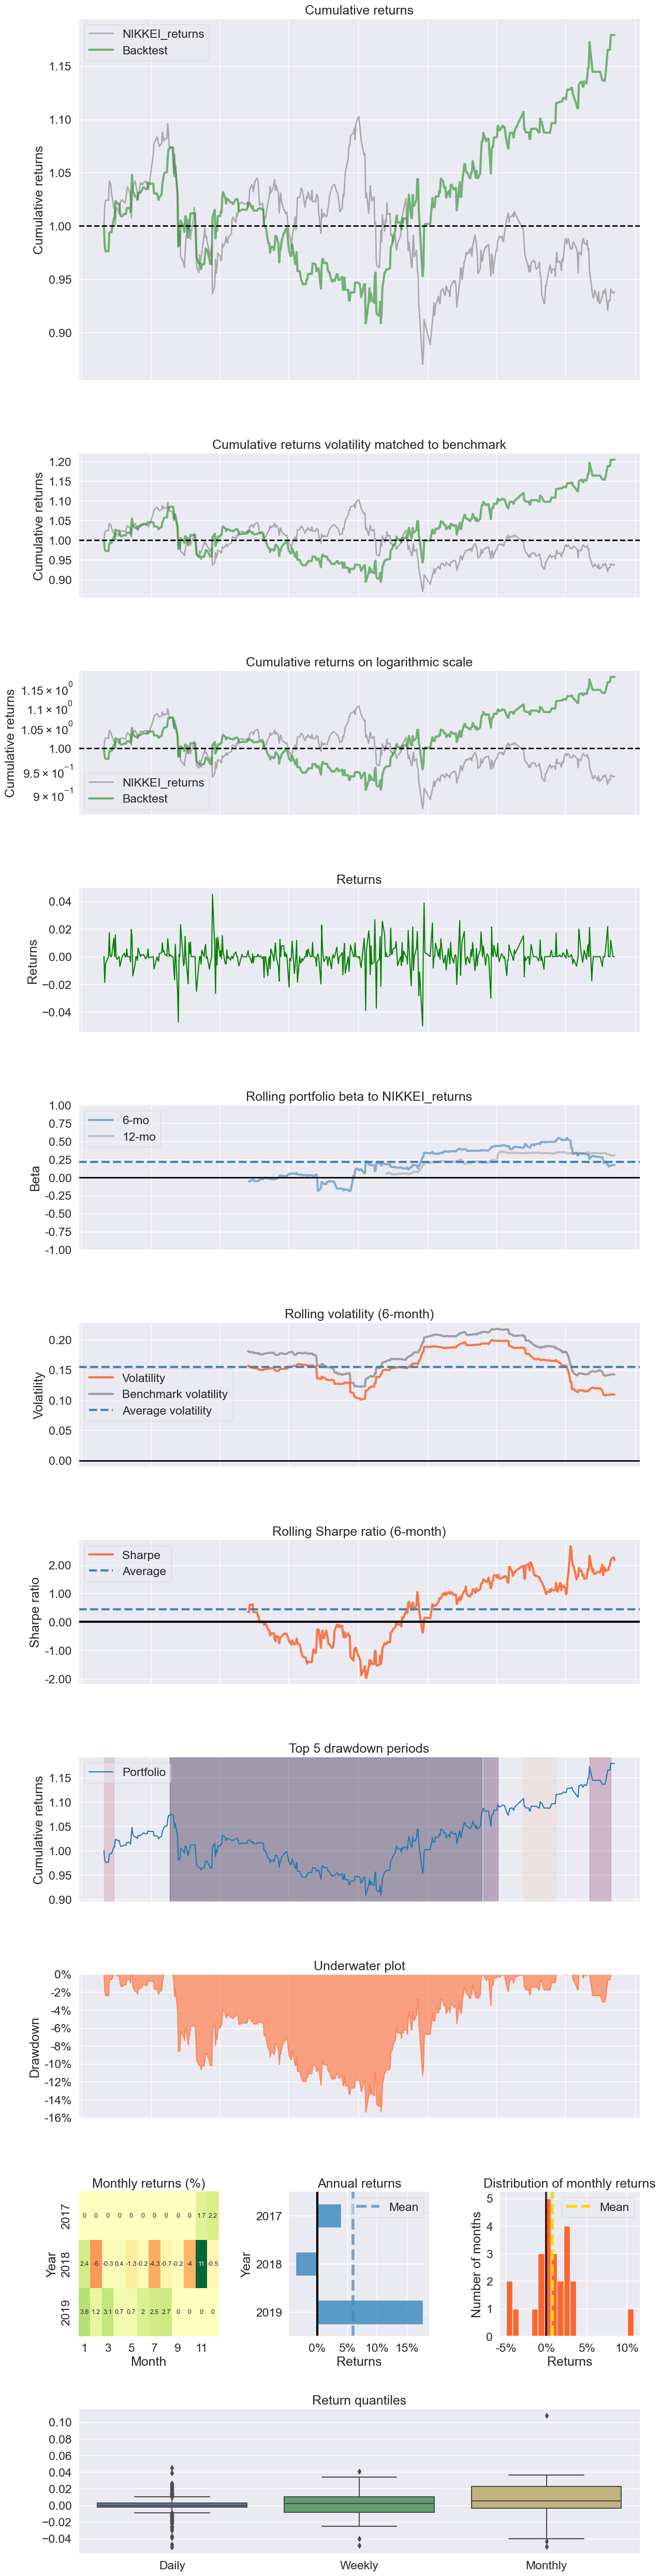

In [30]:
# Creating pyfolio tear sheet
pf.create_returns_tear_sheet(strategy_data['strategy_returns'], benchmark_rets = strategy_data['NIKKEI_returns']) 